<a href="https://colab.research.google.com/github/NishaB65/Telcom-Customer-Churn-Prediction/blob/main/Telcom_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Telcom Customer Churn Prediction**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Configuring the notebook
%matplotlib inline
sns.set()

# Reading the data
churn = pd.read_csv('/content/Telco_Customer_Churn.csv')
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
churn.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [ ]:
n_missing = len(churn[churn['TotalCharges'] == ' '])
print(f'Number of missing values in the TotalCharges column: {n_missing}')

Number of missing values in the TotalCharges column: 11


In [ ]:
# Changing the whitespaces to null values using np.nan
churn.loc[churn['TotalCharges'] == ' ', 'TotalCharges'] = np.nan

# Converting the column to float
churn['TotalCharges'] = churn['TotalCharges'].astype(float)

# Using the column's median to fill the null values
churn['TotalCharges'].fillna(churn['TotalCharges'].median(), inplace=True)

# Checking the values and the format
new_missing = len(churn[churn['TotalCharges'] == ' '])
print(f'Number of missing values in the TotalCharges column: {new_missing}')
print(f'Value type: {churn.TotalCharges.dtypes}')

# Dropping the customerID column
churn.drop('customerID', axis=1, inplace=True)

Number of missing values in the TotalCharges column: 0
Value type: float64


In [ ]:
churn['PaymentMethod'] = churn['PaymentMethod'].str.replace('(automatic)', '').str.replace('(', '').str.replace(')', '').str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
churn['PaymentMethod'].value_counts()

Electronic check    2365
Mailed check        1612
Bank transfer       1544
Credit card         1522
Name: PaymentMethod, dtype: int64

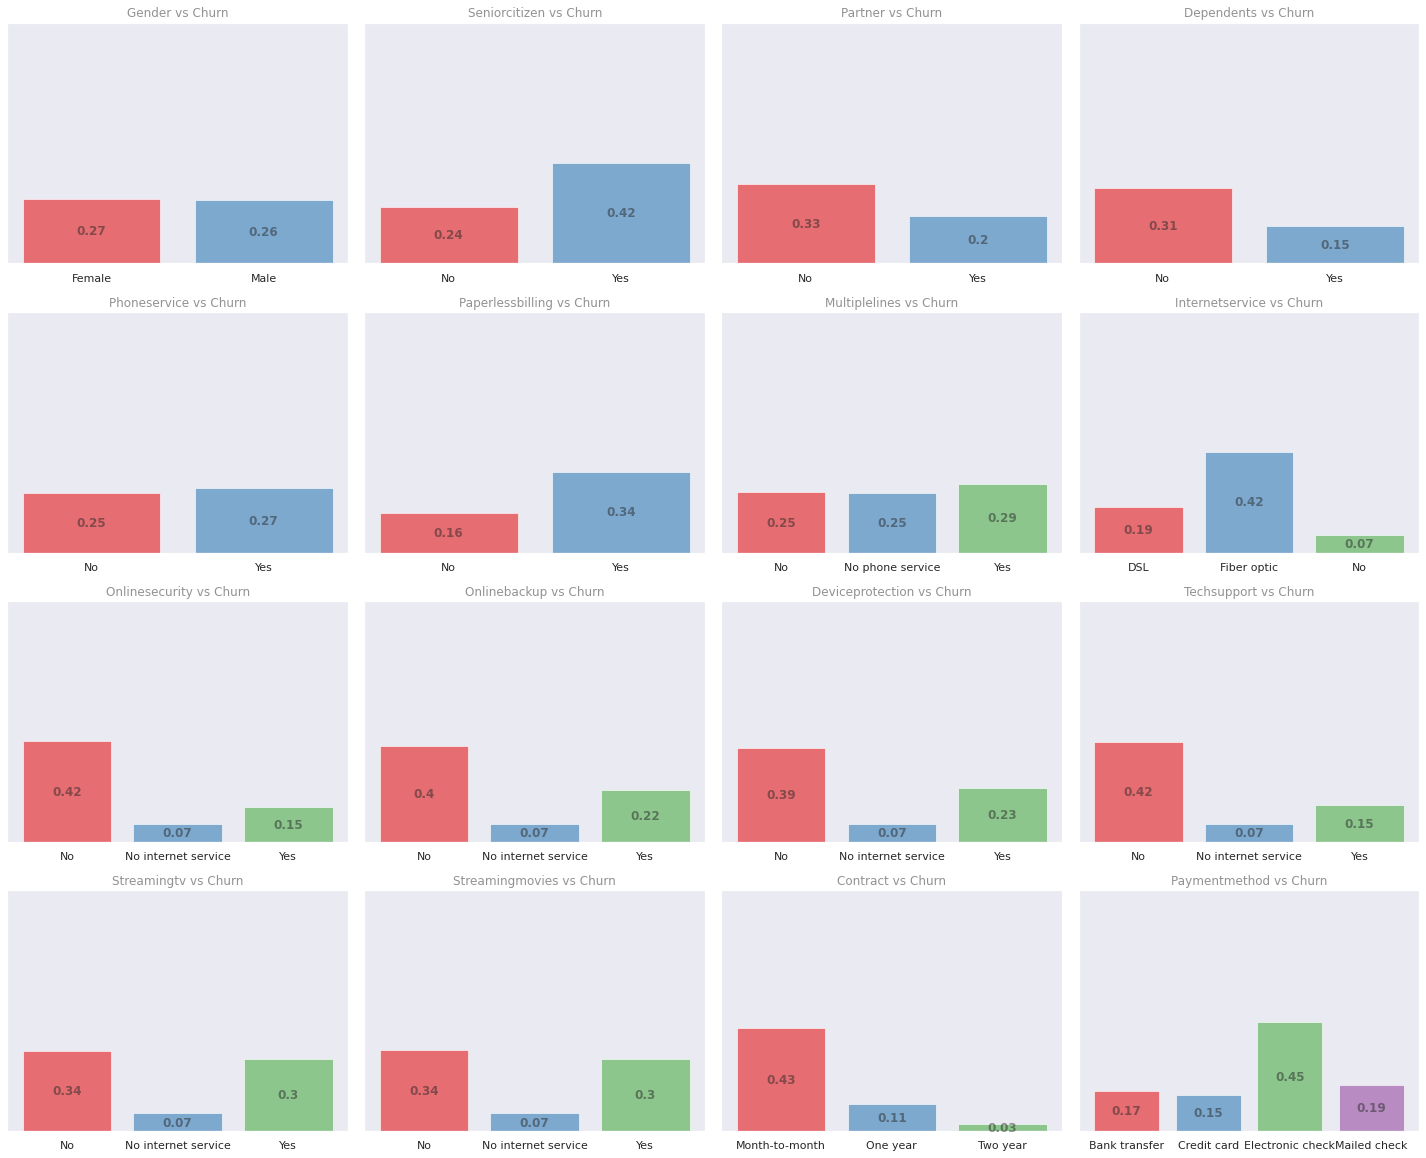

In [ ]:
# Transforming the values in the Churn and SeniorCitizen columns
churn.loc[churn['Churn'] == 'No','Churn'] = 0 
churn.loc[churn['Churn'] == 'Yes','Churn'] = 1
churn['Churn'] = churn['Churn'].astype(int)
churn.loc[churn['SeniorCitizen'] == 0,'SeniorCitizen'] = 'No' 
churn.loc[churn['SeniorCitizen'] == 1,'SeniorCitizen'] = 'Yes'

# Creating the lists
binary = [col for col in churn.columns if len(churn[col].unique()) == 2 and col != 'Churn']
categorical = [col for col in churn.columns if 2 < len(churn[col].unique()) < 5]
bin_cat = binary + categorical

# Plotting
fig = plt.figure(figsize=(20,20))
    
for i in range(len(bin_cat)):
    churn_plot = churn.groupby(bin_cat[i]).Churn.mean()
    ax = fig.add_subplot(5, 4, i+1)
    rects = ax.bar(churn_plot.index, churn_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.grid(False)
    ax.set_ylim(0,1)
    ax.tick_params(labelleft=False)
    ax.set_title(f'{bin_cat[i].title()} vs Churn', alpha=0.5)
    
    for rect in (rects):
        height = rect.get_height()
        ax.text(x=rect.get_x() + rect.get_width() / 2, y=height * 0.5, s=round(height, 2), ha='center', va='center', alpha=0.5, fontweight='bold')

plt.tight_layout()
plt.show()

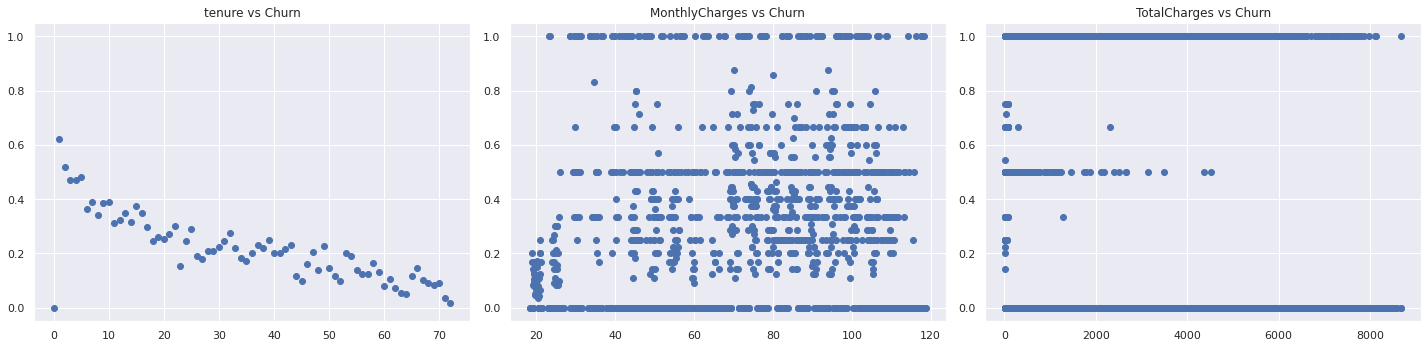

In [ ]:
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig = plt.figure(figsize=(20, 5))

for i in range(len(numeric_columns)):
    num_plot = churn.groupby(numeric_columns[i]).Churn.mean()
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(num_plot.index, num_plot)
    ax.set_title(f'{numeric_columns[i]} vs Churn')
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


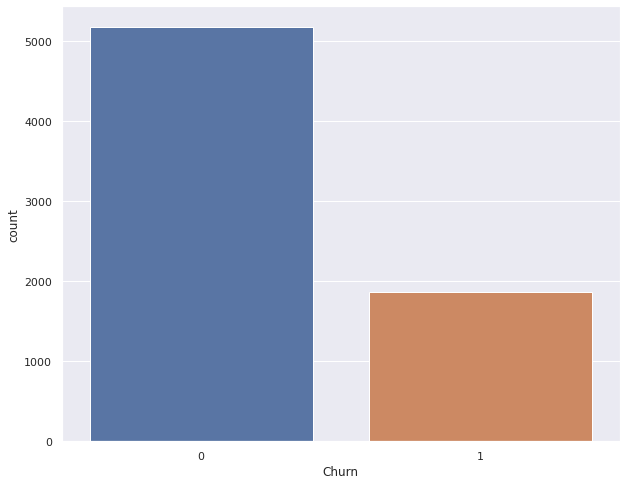

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(churn['Churn'])
plt.show()

In [ ]:
for col in binary:
    le = LabelEncoder().fit(churn[col])
    churn[col] = le.transform(churn[col])

churn = pd.get_dummies(churn, columns=categorical)

churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


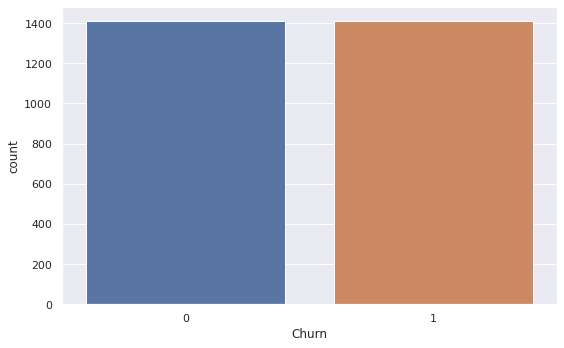

In [ ]:
x = churn.drop('Churn', axis=1)
y = churn['Churn']

x_train, x_test, y_train, y_test = train_test_split(x, y)

rus = RandomUnderSampler()

x_rus, y_rus = rus.fit_resample(x_train, y_train)

fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(y_rus)

plt.tight_layout()
plt.show()

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_rus = scaler.transform(x_rus)

In [ ]:
# Training the models
logreg_balanced = cross_validate(LogisticRegression(), x_rus, y_rus, cv=5, scoring=['recall', 'precision'])
logreg_unbalanced = cross_validate(LogisticRegression(), x_train, y_train, cv=5, scoring=['recall', 'precision'])

trees_balanced = cross_validate(DecisionTreeClassifier(), x_rus, y_rus, cv=5, scoring=['recall', 'precision'])
trees_unbalanced = cross_validate(DecisionTreeClassifier(), x_train, y_train, cv=5, scoring=['recall', 'precision'])

svm_balanced = cross_validate(SVC(), x_rus, y_rus, cv=5, scoring=['recall', 'precision'])
svm_unbalanced = cross_validate(SVC(),  x_train, y_train, cv=5, scoring=['recall', 'precision'])

xgb_balanced = cross_validate(XGBClassifier(), x_rus, y_rus, cv=5, scoring=['recall', 'precision'])
xgb_unbalanced = cross_validate(XGBClassifier(), x_train, y_train, cv=5, scoring=['recall', 'precision'])

In [ ]:
# Storing the results in a DataFrame
summary = pd.DataFrame({
            'labels': ['recall', 'precision'],
            'logreg_balanced': [logreg_balanced['test_recall'].mean(), logreg_balanced['test_precision'].mean()],
            'logreg_unbalanced': [logreg_unbalanced['test_recall'].mean(), logreg_unbalanced['test_precision'].mean()],
            'trees_balanced': [trees_balanced['test_recall'].mean(), trees_balanced['test_precision'].mean()],
            'trees_unbalanced': [trees_unbalanced['test_recall'].mean(), trees_unbalanced['test_precision'].mean()],
            'svm_balanced': [svm_balanced['test_recall'].mean(), svm_balanced['test_precision'].mean()],
            'svm_unbalanced': [svm_unbalanced['test_recall'].mean(), svm_unbalanced['test_precision'].mean()],
            'xgb_balanced': [xgb_balanced['test_recall'].mean(), xgb_balanced['test_precision'].mean()],
            'xgb_unbalanced': [xgb_unbalanced['test_recall'].mean(), xgb_unbalanced['test_precision'].mean()]           
}
).set_index('labels')
summary.index.name=None
     
summary.style.applymap(lambda x: 'background-color: lightgreen' if x >= 0.7 else '')

,logreg_balanced,logreg_unbalanced,trees_balanced,trees_unbalanced,svm_balanced,svm_unbalanced,xgb_balanced,xgb_unbalanced
recall,0.810794,0.557061,0.691028,0.516663,0.793061,0.520923,0.806528,0.529404
precision,0.750432,0.661006,0.694166,0.484455,0.739572,0.659390,0.754222,0.669862


In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
log_reg = LogisticRegression()

param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'C': [0.001, 0.01, 1, 10, 100]}

search = GridSearchCV(log_reg, param_grid, scoring='recall', cv=kfold)
result = search.fit(x_rus, y_rus)

print(f'Best recall: {result.best_score_} for {result.best_params_}')

Best recall: 0.8561586848106659 for {'C': 0.001, 'solver': 'liblinear'}


In [ ]:
xgb = XGBClassifier(learning_rate=0.1)

param_grid = {'n_estimators':range(0,1000,50)}

search = GridSearchCV(xgb, param_grid, scoring='recall', cv=kfold)
result = search.fit(x_rus, y_rus)

print(f'Best recall: {result.best_score_} for {result.best_params_}')

Best recall: 0.8121770292960429 for {'n_estimators': 100}


In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100)

param_grid = {'max_depth':range(1,8,1),
              'min_child_weight':range(1,5,1)}

search = GridSearchCV(xgb, param_grid, scoring='recall', cv=kfold)
result = search.fit(x_rus, y_rus)

print(f'Best recall: {result.best_score_} for {result.best_params_}')

Best recall: 0.8206901736711526 for {'max_depth': 1, 'min_child_weight': 1}


In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=1 , min_child_weight=1)

param_grid = {'gamma':[i/10.0 for i in range(0,5)]}

search = GridSearchCV(xgb, param_grid, scoring='recall', cv=kfold)
result = search.fit(x_rus, y_rus)

print(f'Best recall: {result.best_score_} for {result.best_params_}')

Best recall: 0.8199859659674711 for {'gamma': 0.0}


In [ ]:
xgb = XGBClassifier(n_estimators=100, max_depth=1 , min_child_weight=1, gamma=0)

param_grid = {'learning_rate':[0.001, 0.01, 0.1, 1]}

search = GridSearchCV(xgb, param_grid, scoring='recall', cv=kfold)
result = search.fit(x_rus, y_rus)

print(f'Best recall: {result.best_score_} for {result.best_params_}')

Best recall: 0.8957973084730471 for {'learning_rate': 0.001}


              precision    recall  f1-score   support

           0       0.92      0.56      0.70      1303
           1       0.41      0.85      0.55       458

    accuracy                           0.64      1761
   macro avg       0.66      0.71      0.63      1761
weighted avg       0.78      0.64      0.66      1761



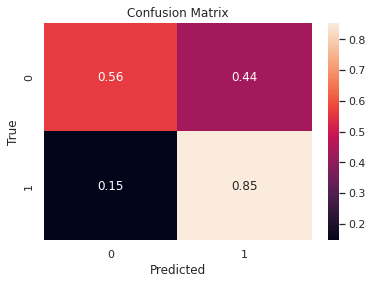

In [ ]:
model_xgb = XGBClassifier(learning_rate=0.001, n_estimators=100, max_depth=1 , min_child_weight=1, gamma=0)
model_xgb.fit(x_rus, y_rus)
y_pred_xgb = model_xgb.predict(x_test)

print(classification_report(y_test, y_pred_xgb))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_ylabel('True')
ax.set_xlabel('Predicted')

plt.show()

              precision    recall  f1-score   support

           0       0.92      0.36      0.52      1303
           1       0.33      0.91      0.49       458

    accuracy                           0.50      1761
   macro avg       0.63      0.64      0.50      1761
weighted avg       0.77      0.50      0.51      1761



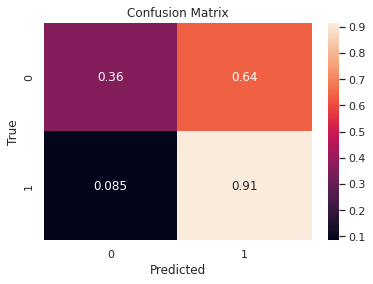

In [ ]:
model_svm = SVC(kernel='poly', C=0.01)
model_svm.fit(x_rus, y_rus)
y_pred_svm = model_svm.predict(x_test)

print(classification_report(y_test, y_pred_svm))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_svm, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_ylabel('True')
ax.set_xlabel('Predicted')

plt.show()